In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
from xmeos import eoslib

from collections import OrderedDict
CONSTS = models.CONSTS

In [2]:
# from xmeos import eoslib
# eos_mod = eoslib.MgSiO3_RTPress()


In [3]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [4]:
datamodel = analysis['datamodel']
datamodel_dK09 = analysis['datamodel_dK09']
data = datamodel['data']
eos_mod = datamodel['eos_mod']
eos_mod_dK09 = datamodel_dK09['eos_mod']

props_Lange = analysis['props_Lange']
props_Ghiorso = analysis['props_Ghiorso']

In [5]:
eos_mod.apply_electronic = True
eos_mod_dK09.apply_electronic = True

In [6]:
props_Lange


{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

In [7]:
props_S11 = eos_mod.material_properties(props_Lange['P'],props_Lange['T'])
props_dK09 = eos_mod_dK09.material_properties(props_Lange['P'],props_Lange['T'])


tbl = pd.DataFrame()
tbl['property'] = pd.Series([
    r'$V$ [Å$^3$/atom]', r'$K_T$ [GPa]', r'$K_S$ [GPa]', 
    r'$\alpha$ [$10^{-5}$ $K^{-1}$]', r'$C_V$ [$Nk_B$]', r'$\gamma$'])
tbl['S11'] = pd.Series([
    props_S11['V'], props_S11['KT'], props_S11['KS'], 1e5*props_S11['therm_exp'],
    props_S11['Cv'][0], props_S11['gamma']])
tbl['dK09'] = pd.Series([
    props_dK09['V'], props_dK09['KT'], props_dK09['KS'], 1e5*props_dK09['therm_exp'],
    props_dK09['Cv'][0], props_dK09['gamma']])
tbl['exp'] = pd.Series([
    props_Lange['V'], props_Lange['KT'], None, 1e5*props_Lange['alpha'],
    None, None])
display(tbl)

,property,S11,dK09,exp
0,$V$ [Å$^3$/atom],11.790828,12.458559,12.803751
1,$K_T$ [GPa],10.487931,21.361021,19.350011
2,$K_S$ [GPa],10.871890,22.987846,NaN
3,$\alpha$ [$10^{-5}$ $K^{-1}$],10.195033,10.682278,8.481830
4,$C_V$ [$Nk_B$],4.254306,4.831828,NaN
5,$\gamma$,0.214640,0.426147,NaN


In [8]:
def init_param_tbl():
    param_tex_lbl = OrderedDict()
    param_tex_lbl['T0'] = r"$T_0$ [K]"
    param_tex_lbl['mexp'] = r"$m$"
    param_tex_lbl['V0'] = r"$V_0$ [$\AA^3$/atom]"
    param_tex_lbl['K0'] = r"$K_0$ [GPa]"
    param_tex_lbl['KP0'] = r"$K'_0$"
    param_tex_lbl['E0'] = r"$E_0$ [eV/atom]"
    param_tex_lbl['gamma0'] = r"$\gamma_0$"
    param_tex_lbl['gammap0'] = r"$\gamma'_0$"

    for ind in np.arange(4+1):
        param_tex_lbl['_bcoef_{:d}'.format(ind)] = r"$b_{:d}$ [eV/atom]".format(ind)
    
    param_tbl = pd.DataFrame()
    param_tbl['Parameter'] = pd.Series(
        [param_tex_lbl[name] for name in param_tex_lbl])
    
    return param_tbl, param_tex_lbl

def get_table_display(values, errors, TOL=1e-6):
    decimals = 1-np.floor(np.log10(errors))

    error_sigfigs = np.round(errors*10**(decimals))
    tbl_display = []

    for val,err,errsig,dec in zip(values,errors,error_sigfigs,decimals):    
        # print(val, ' ', err)
        try:
            str_format = '{:.' + '{:.0f}'.format(dec) + 'f}({:2.0f})'
            val_str = str_format.format(val,errsig)

        except:
            val_diff = np.abs(val-np.round(val,decimals=0))
            if val_diff < TOL:
                val_str = str(int(val))
            else:
                val_str = str(val)
        
        # print(val_str)
        # print('===')
        tbl_display.append(val_str)
        
    return tbl_display

def add_to_param_tbl(model_title, datamodel, param_tbl, param_tex_lbl):
    
    eos_mod = datamodel['eos_mod']
    param_tbl_fit = datamodel['posterior']['param_tbl']
    
    T0 = eos_mod.get_refstate()['T0'] 
    eos_params = eos_mod.get_params()  
    eos_params['T0'] = T0
    
    value_list = []
    error_list = []
    
    for par in param_tex_lbl:
        val = eos_params[par]
        mask = param_tbl_fit['name']==par
        
        if mask.any():
            val = float(param_tbl_fit['value'][mask])
            err = float(param_tbl_fit['error'][mask])
            
        elif par in eos_params:
            val = eos_params[par]
            err = np.nan
        
        value_list.append(val)
        error_list.append(err)
    
    values = np.array(value_list)
    errors = np.array(error_list)
    tbl_display = get_table_display(values, errors)
    param_tbl[model_title] = pd.Series(tbl_display) 
    pass
    
param_tbl, param_tex_lbl = init_param_tbl()
add_to_param_tbl('Spera et al. (2011)', datamodel, param_tbl, param_tex_lbl)
add_to_param_tbl('de Koker. (2009)', datamodel_dK09, param_tbl, param_tex_lbl)
display(param_tbl)

,Parameter,Spera et al. (2011),de Koker. (2009)
0,$T_0$ [K],3000,3000
1,$m$,0.6,0.6
2,$V_0$ [$\AA^3$/atom],12.949(18),14.74(11)
3,$K_0$ [GPa],13.20(19),9.77(72)
4,$K'_0$,8.238(49),7.42(15)
5,$E_0$ [eV/atom],-20.5953(19),-6.850(15)
6,$\gamma_0$,0.1899(53),0.282(22)
7,$\gamma'_0$,-1.940(35),-1.35(15)
8,$b_0$ [eV/atom],0.9821(97),1.118(55)
9,$b_1$ [eV/atom],0.615(60),-0.05(12)


<IPython.core.display.Javascript object>


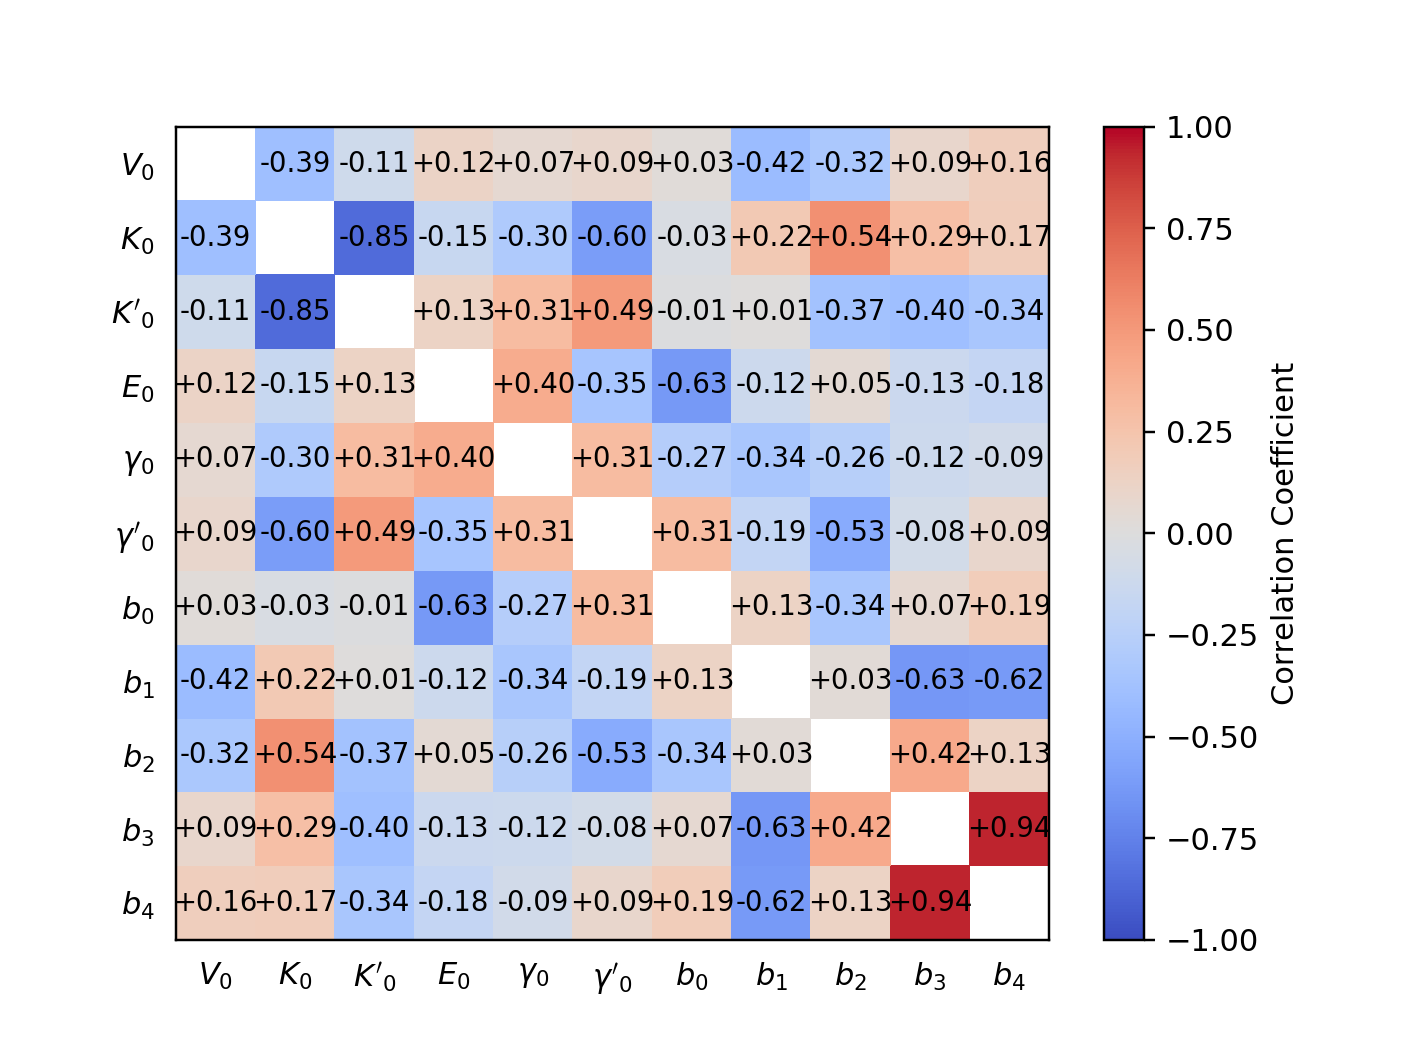

In [27]:
def fit_param_symbols():
    param_tex_sym = OrderedDict()
    param_tex_sym['V0'] = r"$V_0$"
    param_tex_sym['K0'] = r"$K_0$"
    param_tex_sym['KP0'] = r"$K'_0$"
    param_tex_sym['E0'] = r"$E_0$"
    param_tex_sym['gamma0'] = r"$\gamma_0$"
    param_tex_sym['gammap0'] = r"$\gamma'_0$"

    for ind in np.arange(4+1):
        param_tex_sym['_bcoef_{:d}'.format(ind)] = r"$b_{:d}$".format(ind)
    
    
    return param_tex_sym

plt.figure()

param_tex_sym = fit_param_symbols()
posterior = datamodel['posterior']
corr = posterior['corr']
if corr is not None:

    param_labels = [param_tex_sym[name] for name in posterior['param_names']]


    cmap = plt.get_cmap('coolwarm')
    Nparam = len(param_labels)

    corr_plt = np.flipud(np.ma.masked_where(np.eye(Nparam),corr))
    plt.pcolormesh(corr_plt,cmap=cmap)


    # plt.imshow(corr, cmap=cmap)
    plt.clim(-1,1)
    plt.colorbar(label=r'Correlation Coefficient')

    plt.xticks(.5+np.arange(len(param_labels)),param_labels)
    plt.yticks(np.flipud(.5+np.arange(len(param_labels))),param_labels)

    for (index,val) in np.ndenumerate(np.flipud(corr)):
        if index[1]!=Nparam-1-index[0]:
            plt.text(index[1]+.5,index[0]+.5,'%+.2f'%(val),fontsize=9,
                     horizontalalignment='center', verticalalignment='center')

    plt.setp(plt.gca().get_xticklines(),visible=False);
    plt.setp(plt.gca().get_yticklines(),visible=False);

In [9]:

param_tbl = pd.DataFrame()
param_tbl['param'] = pd.Series([
    r'$V$ [Å$^3$/atom]', r'$K_T$ [GPa]', r'$K_S$ [GPa]', 
    r'$\alpha$ [$10^{-5}$ $K^{-1}$]', r'$C_V$ [$Nk_B$]', r'$\gamma$'])
param_tbl['S11'] = pd.Series([
    props_S11['V'], props_S11['KT'], props_S11['KS'], 1e5*props_S11['therm_exp'],
    props_S11['Cv'][0], props_S11['gamma']])
param_tbl['dK09'] = pd.Series([
    props_dK09['V'], props_dK09['KT'], props_dK09['KS'], 1e5*props_dK09['therm_exp'],
    props_dK09['Cv'][0], props_dK09['gamma']])
param_tbl['exp'] = pd.Series([
    props_Lange['V'], props_Lange['KT'], None, 1e5*props_Lange['alpha'],
    None, None])
display(param_tbl)

,param,S11,dK09,exp
0,$V$ [Å$^3$/atom],11.790828,12.458559,12.803751
1,$K_T$ [GPa],10.487931,21.361021,19.350011
2,$K_S$ [GPa],10.871890,22.987846,NaN
3,$\alpha$ [$10^{-5}$ $K^{-1}$],10.195033,10.682278,8.481830
4,$C_V$ [$Nk_B$],4.254306,4.831828,NaN
5,$\gamma$,0.214640,0.426147,NaN


In [11]:
eos_mod = analysis['eos_mod']
data = analysis['datasets']['Spera2011']

In [13]:
eos_mod = datamodel['eos_mod']
eos_mod.apply_electronic = False
T0 = eos_mod.get_refstate()['T0']
V0 = eos_mod.get_params()['V0']
tbl = datamodel['data']['table']
Tlbl = data['T_labels']

delT = Tlbl[1]-Tlbl[0]

cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.3,1.2,1001)

<IPython.core.display.Javascript object>


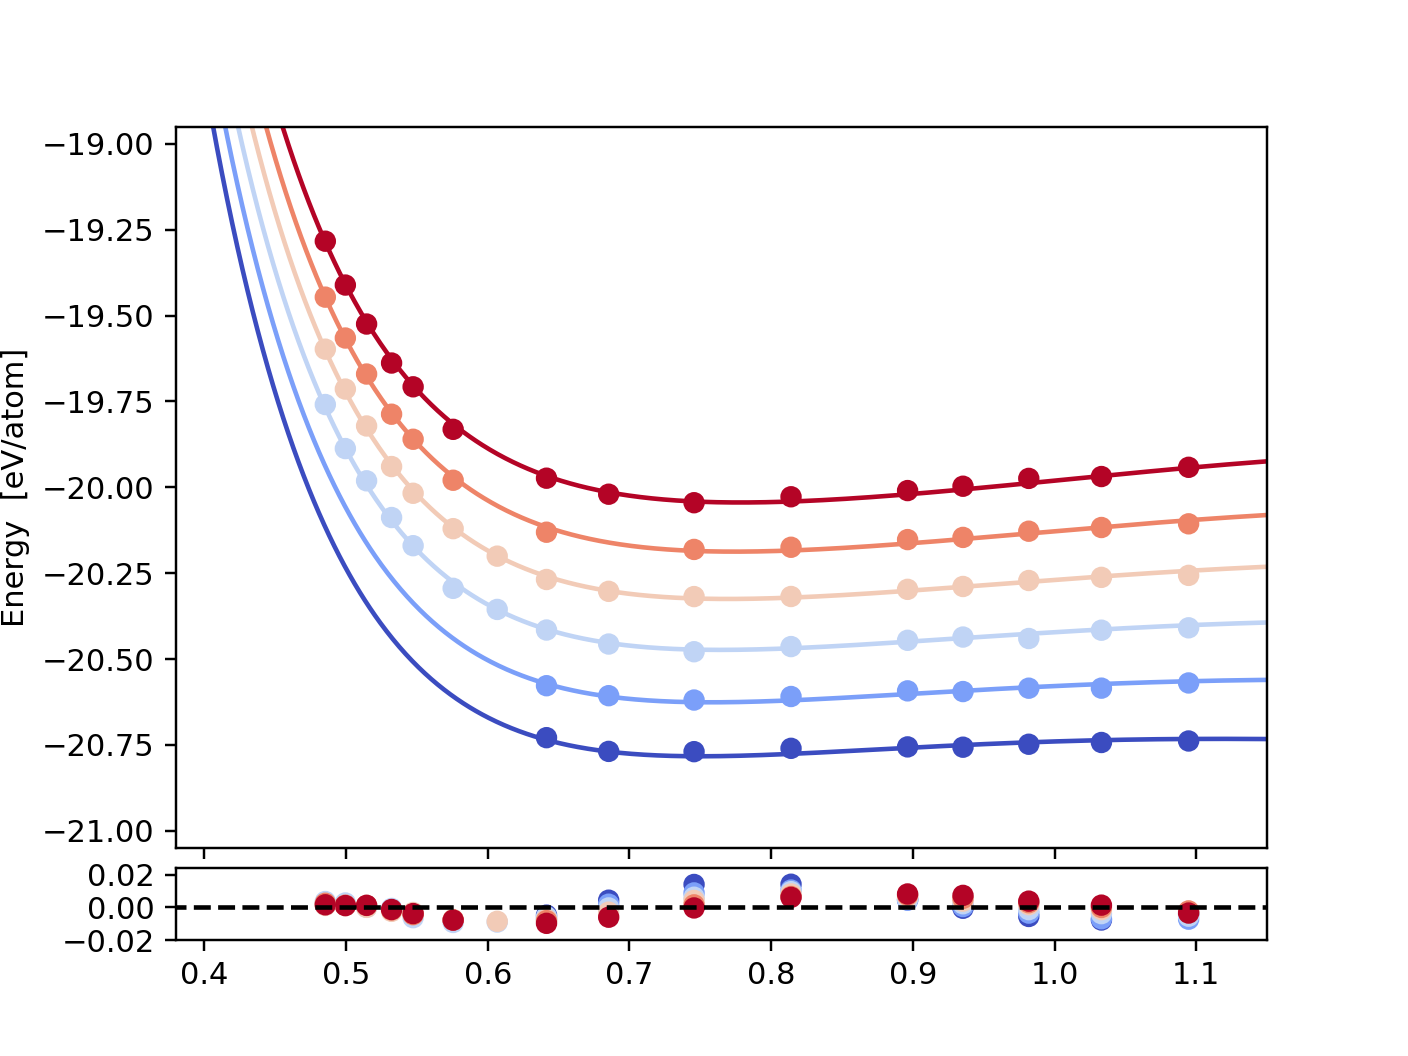

[]

In [14]:
plt.figure()


for iT in data['T_avg']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
cscatter = plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')

mainax = plt.gca()

divider = make_axes_locatable(mainax)
residax = divider.append_axes("bottom", size="10%", pad=0.09)

residax.scatter(
    tbl['V']/V0, tbl['E']-eos_mod.internal_energy(tbl['V'], tbl['T']),
    c=tbl['T'], cmap=cmap)
residax.plot([0,2],[0,0],'k--')
residax.set_xlim(.38,1.15)
mainax.set_xlim(.38,1.15)
mainax.set_ylim(-21.05,-18.95)
mainax.set_xticklabels('')

# cbar = plt.colorbar(cscatter,ticks=Tlbl,label=r'Temp. [K]', cax=cax)
# cbar = plt.colorbar(cax=cax)
# plt.clim(clims)
# cbar.set_ticks(Tlbl)
# plt.ylim(-21,-19)

In [30]:
def plot_model_fit_results(Tlbl_a,datamodel,
                           Nsamp=101,Vbnds=[0.4,1.2]):

    data = datamodel['data']
    eos_mod = datamodel['eos_mod']
    
    V0 = eos_mod.get_params()['V0']
    Tlbl = data['T_labels']
    delT = Tlbl[1]-Tlbl[0]
    T_avg = data['T_avg']
    
    

    err_d = datamod_d['posterior_d']['err']

    Vgrid = np.linspace(Vbnds[0],Vbnds[1],Nsamp)*V0


    E_grid_a, P_grid_a, dPdT_grid_a = eval_model( Vgrid_a, Tgrid_a, eos_d )
    E_mod_a = full_mod.energy(data_d['V'],data_d['T'],eos_d)
    P_mod_a = full_mod.press(data_d['V'],data_d['T'],eos_d)

    Plims=[-5.0,181.0]
    Vlims=[5.25,14.5]
    Elims=[-21.05,-18.95]
    Presid_ticks = [-2,0,2]
    Eresid_ticks = [-.02,0,.02]
    Plbl = r'Pressure  [GPa]'
    Elbl = r'Internal Energy  [eV / atom]'
    Vlbl = r'$V / V_0$'
    # Vlbl = r'Volume  [$\AA^3$ / atom]'

    # hfigEP = plot_model_mismatch((P_grid_a, E_grid_a, Tgrid_a, ),
    #                              (P_a,E_a,T_a,E_mod_a),
    #                              (Plims,Elims),(Plbl,Elbl),Tlbl_a,
    #                              Eresid_ticks,err_d['E'])

    hfig, ax_main_l, ax_resid_l = setup_model_mismatch_plot(2,Tlbl_a)


    do_plot_model_mismatch((Vgrid_a/V0, P_grid_a, Tgrid_a),
                           (V_a/V0,P_a,T_a,P_mod_a),
                           (Vlims/V0,Plims),('',Plbl),Tlbl_a,
                           Presid_ticks,err_d['P'],hfig,ax_main_l[1],
                           ax_resid_l[1],xtick_lbl=False,show_colbar=True,
                           panel_lbl='a')


    do_plot_model_mismatch((Vgrid_a/V0, E_grid_a, Tgrid_a),
                           (V_a/V0,E_a,T_a,E_mod_a),
                           (Vlims/V0,Elims),(Vlbl,Elbl),Tlbl_a,
                           Eresid_ticks,err_d['E'],hfig,ax_main_l[0],
                           ax_resid_l[0],show_colbar=False,
                           panel_lbl='b')

    plt.draw()

    # return hfigPV, hfigEV, hfigEP
    # return hfig
    hfig.set_size_inches(8,10)
    hfig.set_size_inches(8,10)

    return ax_main_l, ax_resid_l

def do_plot_model_mismatch((xgrid_a, ygrid_a, zgrid_a),(x_a,y_a,z_a,ymod_a),
                           (xlims,ylims),(xlbl,ylbl),zlbl_a,yresid_ticks,
                           yresid_err,hfig,ax_main,ax_resid,xtick_lbl=True,
                           show_colbar=True,panel_lbl='a'):

    # from IPython import embed; embed(); import ipdb; ipdb.set_trace()

    shp = ygrid_a.shape
    if xgrid_a.shape != shp:
        xgrid_tbl_a, zgrid_tbl_a = np.meshgrid(xgrid_a,zgrid_a)
        xgrid_a = xgrid_tbl_a


    cmap_cont=plt.get_cmap('coolwarm')
    col_mod_a = cmap_cont( np.linspace(0,1,zlbl_a.size) )

    cmap=plt.get_cmap('coolwarm',zlbl_a.size)



    ax_main.scatter( x_a, y_a,c=z_a,s=50,lw=0,cmap=cmap)
    [ax_main.plot(ixgrid_a, iygrid_a,'-',color=icol_a,label=izlbl) \
     for ixgrid_a, iygrid_a,icol_a,izlbl  in zip(xgrid_a,ygrid_a,col_mod_a,zgrid_a)]
    ax_main.set_xlim(xlims)
    ax_main.set_ylim(ylims)
    ax_main.set_xticklabels('')

    xpanel_lbl = 0.95*xlims[1] + 0.05*xlims[0]
    ypanel_lbl = 0.9*ylims[1] + 0.1*ylims[0]
    ax_main.text(xpanel_lbl,ypanel_lbl,panel_lbl,fontsize=14,weight='bold')


    xrange_a = np.array([np.min(xgrid_a[:]),np.max(xgrid_a[:])])
    ax_resid.add_patch(patches.Rectangle((xlims[0],-yresid_err),
                                         xlims[1]-xlims[0],2*yresid_err,
                                         facecolor='#DCDCDC',edgecolor='none',
                                         zorder=0))
    ax_resid.plot(xrange_a,0.0*xrange_a,'k--',zorder=1)
    hlbl=ax_resid.scatter( x_a, y_a-ymod_a,c=z_a,s=50,lw=0,cmap=cmap,zorder=2)
    ax_resid.set_xlim(xlims)
    ax_resid.set_ylim([1.1*yresid_ticks[0],1.1*yresid_ticks[-1]])
    ax_resid.set_yticks(yresid_ticks)
    if not xtick_lbl:
        ax_resid.set_xticklabels('')

    ax_resid.set_xlabel(xlbl)
    ax_main.set_ylabel(ylbl)


    # if show_colbar:
    #     ticks = zlbl_a
    #     label = 'Temperature [K]'
    #     add_shared_colorbar(label, ticks, pos=[.85,.1,.03,.88], cmap=cmap)

    # return hfig
    pass


SyntaxError: invalid syntax (<ipython-input-30-9750aae48244>, line 65)

In [15]:

def plot_adiabat_melting_curve(Tlbl, Pgrid, Tad_grid, Tad_grid_dK09,
                               Vad_grid, Vad_grid_dK09, 
                               show_liquidus=True, show_cbar=True):
    
    Tad2540_M09_a = np.loadtxt('data/MgSiO3-2540ad-Mosenfelder2009.csv',delimiter=',')
    Tad2500_S09_a = np.loadtxt('data/MgSiO3-2500ad-Stixrude2009.csv',delimiter=',')

    liqdat_d = load_liquidus_data()
    
    Pmod = np.linspace(0,135,1001)
    Tad2500_S11 = Tad_grid[2]
    Tad2500_dK09 = Tad_grid_dK09[2]

    fun_S11 = interpolate.interp1d(Pgrid,Tad2500_S11-Tad2500_S11[0],'cubic')
    fun_M09 = interpolate.interp1d(
        Tad2540_M09_a[:,0], Tad2540_M09_a[:,1]-Tad2540_M09_a[0,1], 'cubic')
    fun_S09 = interpolate.interp1d(
        Tad2500_S09_a[:,0], Tad2500_S09_a[:,1]-Tad2500_S09_a[0,1], 'cubic')
    fun_dK09 = interpolate.interp1d(
        Pgrid,Tad2500_dK09-Tad2500_dK09[0], 'cubic')
    
    cmap = plt.get_cmap('coolwarm',len(Tlbl))
    delT = Tlbl[1]-Tlbl[0]
    clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

    plt.figure()
        
    if show_cbar:
        plt.clf()
        cbarinfo = plt.scatter(0*Tad_grid[:,0], Tad_grid[:,0],
                               c=Tlbl,s=50,lw=0,cmap=cmap)
        plt.clim(Tlbl[0]-0.5*delT,Tlbl[-1]+0.5*delT)
        plt.clf()
        
    ax_main = plt.subplot(211)
    ax_resid = plt.subplot(212)
    ax_main.set_xticklabels([])
    plt.draw()

    pos_main = [.125,.27,.7,.68]
    pos_resid = [.125,.1,.66,.15]
    
    ax_main.set_position(pos_main)
    ax_resid.set_position(pos_resid)

    for iT, Tad, Tad_dK09 in zip(Tlbl, Tad_grid, Tad_grid_dK09):
        icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
        ax_main.plot(Pgrid, Tad, '-', color=icol)
        ax_main.plot(Pgrid, Tad_dK09, '--', color=icol)
    
    
    ax_main.set_ylim(1250,5000)
    ax_main.set_xlim(0,136)
    ax_main.set_xlabel('Pressure  [GPa]')
    ax_main.set_ylabel('Temperature  [K]')
    
    if show_liquidus:
        # plt.plot(liqdat_d['UM'][:,0] ,liqdat_d['UM'][:,1] ,'k-',lw=2,color=[.3,.3,.3])
        ax_main.plot(liqdat_d['UM'][:,0] ,liqdat_d['UM'][:,1] ,'k-',lw=2)
        ax_main.plot(liqdat_d['A11'][:,0],liqdat_d['A11'][:,1],'k-.',lw=2)
        ax_main.plot(liqdat_d['S09'][:,0],liqdat_d['S09'][:,1],'k--',lw=2)
        # plt.plot(PTsol_a[:,0],PTsol_a[:,1],'k-')
   
    divider = make_axes_locatable(ax_main)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    
    if show_cbar:
        # ax_main.colorbar()
        cbar = plt.colorbar(cbarinfo,ticks=Tlbl,
                            label=r'$T_{\rm pot}$  [K]', 
                            cax=cax)
        # plt.colorbar(im,fraction=0.046, pad=0.04)
        #plt.colorbar()
        pass
        
    icol = cmap((2500-clims[0])/(clims[1]-clims[0]))
    #plt.plot(Tad2540_M09_a[:,0], Tad2540_M09_a[:,1], ':',
    #        color=icol)
    #plt.plot(Tad2500_S09_a[::5,0], Tad2500_S09_a[::5,1], '-x',
    #         ms=3,color=icol,lw=.5)
        
    #plt.colorbar()
    
    Pmod = np.linspace(0,135,31)
    dP = Pmod[1]-Pmod[0]
    Tad2500_S11 = Tad_grid[2]
    Tad2500_dK09 = Tad_grid_dK09[2]

    fun_S11 = interpolate.interp1d(Pgrid,Tad2500_S11-Tad2500_S11[0],'cubic')
    fun_M09 = interpolate.interp1d(
        Tad2540_M09_a[:,0], Tad2540_M09_a[:,1]-Tad2540_M09_a[0,1], 'cubic')
    fun_S09 = interpolate.interp1d(
        Tad2500_S09_a[:,0], Tad2500_S09_a[:,1]-Tad2500_S09_a[0,1], 'cubic')
    fun_dK09 = interpolate.interp1d(
        Pgrid,Tad2500_dK09-Tad2500_dK09[0], 'cubic')
    
    fun_S11 = interpolate.interp1d(Pgrid,Tad2500_S11,'cubic')
    fun_M09 = interpolate.interp1d(
        Tad2540_M09_a[:,0], Tad2540_M09_a[:,1], 'cubic')
    fun_S09 = interpolate.interp1d(
        Tad2500_S09_a[:,0], Tad2500_S09_a[:,1], 'cubic')
    fun_dK09 = interpolate.interp1d(
        Pgrid,Tad2500_dK09, 'cubic')
    
    dev_S09 = 100*(fun_S09(Pmod)-fun_S11(Pmod))/fun_S11(Pmod)
    dev_M09 = 100*(fun_M09(Pmod)-fun_S11(Pmod))/fun_S11(Pmod)
    dev_dK09 = 100*(fun_dK09(Pmod)-fun_S11(Pmod))/fun_S11(Pmod)
    
    deriv_S11 = np.gradient(fun_S11(Pmod),dP)
    deriv_S09 = np.gradient(fun_S09(Pmod),dP)
    deriv_M09 = np.gradient(fun_M09(Pmod),dP)
    deriv_dK09 = np.gradient(fun_dK09(Pmod),dP)
    
    avg_exp_deriv = np.mean(100*(deriv_M09/deriv_S11-1))

    deriv_avg_M09 = np.mean(deriv_M09[Pmod>10])
    deriv_avg_S11 = np.mean(deriv_S11[Pmod>10])
    deriv_avg_S09 = np.mean(deriv_S09[Pmod>10])
    deriv_avg_dK09 = np.mean(deriv_dK09[Pmod>10])
    print('Avg Thermal Derivative')
    print('Spera11 = ',deriv_avg_S11 )    
    print('Mosenfelder09 = ',deriv_avg_M09,100*(deriv_avg_M09/deriv_avg_S11-1))
    print('deKoker09 = ',deriv_avg_dK09,100*(deriv_avg_dK09/deriv_avg_S11-1))
    print('Stixrude09 = ',deriv_avg_S09,100*(deriv_avg_S09/deriv_avg_S11-1))
   
    
    
    # print(avg_exp_deriv)
    # print(np.mean(100*(deriv_dK09/deriv_S11-1)))
    # print(np.mean(100*(deriv_S09/deriv_S11-1)))
    
    ax_resid.plot(Pmod,100*(deriv_dK09/deriv_S11-1),'k--',
                  color=icol,label='dK09',lw=2)
    ax_resid.plot(Pmod,100*(deriv_M09/deriv_S11-1),'k:',
                  color=icol,label='M09',lw=1)
     
    ax_resid.plot(Pmod,100*(deriv_S09/deriv_S11-1),'k-x',
                  color=icol,label='S09',lw=1)
    # ax_resid.set_yscale('log')
    ax_resid.plot([-100,1000],[0,0],'k-',
                  color=icol,label=None,lw=2)
    ax_resid.text(100,-40,'2500 K Adiabat')
    # ax_resid.legend(ncol=4)
    
    ax_resid.set_xlim(0,136)
    ax_resid.set_ylim(-50,50)
    
    ax_resid.set_xlabel('Pressure [GPa]')
    # ax_resid.set_ylabel(r'$\Delta \frac{dT}{dP}$ [%]')
    ax_resid.set_ylabel(r'$\Delta dT/dP$ [%]')
    

        
    pass

In [16]:
def load_liquidus_data():
    # Pthresh = 14.5
    PTliq_S09_a = np.loadtxt('data/MgSiO3-liq-Stixrude2009.csv',delimiter=',')
    PTliq_A11_a = np.loadtxt('data/MgSiO3-liq-Andrault2011.csv',delimiter=',')
    Pthresh = PTliq_A11_a[0,0]

    # mask_UM_a = PTliq_S09_a[:,0]<=Pthresh
    PTliq_UM_a = PTliq_S09_a[PTliq_S09_a[:,0]<=Pthresh]


    Tthresh_S09 = interpolate.interp1d(PTliq_S09_a[:,0],PTliq_S09_a[:,1],kind='linear')(Pthresh)
    Tthresh_A11 = interpolate.interp1d(PTliq_A11_a[:,0],PTliq_A11_a[:,1],kind='linear',fill_value='extrapolate',bounds_error=False)(Pthresh)

    liqdat_d = {}
    liqdat_d['UM'] = np.vstack((PTliq_UM_a,(Pthresh,Tthresh_S09)))
    liqdat_d['S09'] = np.vstack(((Pthresh,Tthresh_S09),PTliq_S09_a[PTliq_S09_a[:,0]>Pthresh]))
    liqdat_d['A11'] = np.vstack(((Pthresh,Tthresh_A11),PTliq_A11_a))
    return liqdat_d

def load_adiabat_data():
    # Tad3200_M09_a = np.loadtxt('data/MgSiO3-3200ad-Mosenfelder2009.csv',delimiter=',')
    # Tad3750_M09_a = np.loadtxt('data/MgSiO3-3750ad-Mosenfelder2009.csv',delimiter=',')
    Tad2540_M09_a = np.loadtxt('data/MgSiO3-2540ad-Mosenfelder2009.csv',delimiter=',')
    Tad2500_S09_a = np.loadtxt('data/MgSiO3-2500ad-Stixrude2009.csv',delimiter=',')

    return 

liqdat_d = load_liquidus_data()

In [17]:
def load_shock_data(datafile='data/shock-data-Mosenfelder2009.csv'):
    shock_dat = pd.read_csv(datafile,delimiter=',')
    melt_en_mask = ((shock_dat['Starting Material']=='Enstatite')&(shock_dat['Phase State']=='melt'))
    melt_glass_mask = ((shock_dat['Starting Material']=='Glass')&(shock_dat['Phase State']=='melt'))

    melt_enpor_mask = ((shock_dat['Starting Material']=='Porous Enstatite')&(shock_dat['Phase State']=='melt'))
    melt_oxmix_mask = ((shock_dat['Starting Material']=='Oxide mix')&(shock_dat['Phase State']=='melt'))

    shock_dat_melt_glass = shock_dat.loc[melt_glass_mask]
    shock_dat_melt_en = shock_dat.loc[melt_en_mask]
    
    return shock_dat_melt_glass, shock_dat_melt_en

def get_melt_rxn_info():    
    shock_dat_melt_glass, shock_dat_melt_en = load_shock_data()
    
    Tmelt = 1816
    

    # Enstatite Hugoniot
    rhoinit_en=np.mean(shock_dat_melt_en['rho0'])
    # rhofaclims_en = [1.59, 1.84]
    rhofaclims_en = np.array([1.6, 1.8])
    # Etrans_en = 2.192455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
    
    #Tmelt_en = 300
    Efus_en = 73*1e3/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
    Eheat_en = 126*(Tmelt-273)/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
    Etrans_en = Eheat_en+Efus_en

    melt_rxn_en = {}
    melt_rxn_en['Tmelt'] = Tmelt    
    melt_rxn_en['rhoinit'] = rhoinit_en
    melt_rxn_en['rhofaclims'] = rhofaclims_en
    melt_rxn_en['Etrans'] = Etrans_en

    # Glass Hugoniot
    rhoinit_glass = np.mean(shock_dat_melt_glass['rho0'])
    # rhofaclims_glass = [1.65, 1.94]
    rhofaclims_glass = [1.65, 1.9]
    # Etrans_glass = 1.862455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
    delE_glass = (2.192455e6-1.862455e6)*1e-3/CONSTS['JperHa']*CONSTS['eVperHa']*eos_mod.molar_mass/CONSTS['Nmol']
    Etrans_glass = Etrans_en - delE_glass
    
    melt_rxn_glass = {}
    melt_rxn_glass['Tmelt'] = Tmelt    
    melt_rxn_glass['rhoinit'] = rhoinit_glass
    melt_rxn_glass['rhofaclims'] = rhofaclims_glass
    melt_rxn_glass['Etrans'] = Etrans_glass
    
    return melt_rxn_glass, melt_rxn_en

def calc_hugoniot(eos_mod, melt_rxn, Tinit=300):
    hugoniot = eos_mod.hugoniot(
        melt_rxn['rhofaclims'], melt_rxn['rhoinit'], Tinit, 
        Etrans=melt_rxn['Etrans'], Ttrans=melt_rxn['Tmelt'],
        isobar_trans=True)
    
    return hugoniot

In [18]:
def plot_hugoniot(shock_dat_melt_glass, shock_dat_melt_en,
                  hugoniot_glass_S11, hugoniot_en_S11,
                  hugoniot_glass_dK09, hugoniot_en_dK09,
                  Plim=[50,225], col_glass=[0,0,0], col_en=[.5,.5,.5]):
    
    f, ax_a = plt.subplots(2, 1, sharex='col')

    ax_a[0].errorbar(shock_dat_melt_glass['P'], shock_dat_melt_glass['rho'],
                     xerr=shock_dat_melt_glass['P err'],
                     yerr=shock_dat_melt_glass['rho err'],
                     fmt='.',color=col_glass)
    ax_a[0].errorbar(shock_dat_melt_en['P'], shock_dat_melt_en['rho'],
                     xerr=shock_dat_melt_en['P err'],
                     yerr=shock_dat_melt_en['rho err'],
                     fmt='.',color=col_en)

    ax_a[0].plot(hugoniot_glass_S11['P_a'],hugoniot_glass_S11['rho_a'],
                 '-',color=col_glass)
    ax_a[0].plot(hugoniot_en_S11['P_a'],hugoniot_en_S11['rho_a'],
                 '-',color=col_en)

    ax_a[0].plot(hugoniot_glass_dK09['P_a'],hugoniot_glass_dK09['rho_a'],
                 '--',color=col_glass)
    ax_a[0].plot(hugoniot_en_dK09['P_a'],hugoniot_en_dK09['rho_a'],
                 '--',color=col_en)

    ax_a[0].set_xlim(Plim[0],Plim[1])
    ax_a[0].set_ylabel(u'Density [g/cm$^3$]')

    
    
    ax_a[1].plot(hugoniot_glass_S11['P_a'],hugoniot_glass_S11['T_a'],
                 '-',color=col_glass)
    ax_a[1].plot(hugoniot_en_S11['P_a'],hugoniot_en_S11['T_a'],
                 '-',color=col_en)

    ax_a[1].plot(hugoniot_glass_dK09['P_a'],hugoniot_glass_dK09['T_a'],
                 '--',color=col_glass)
    ax_a[1].plot(hugoniot_en_dK09['P_a'],hugoniot_en_dK09['T_a'],
                 '--',color=col_en)

    ax_a[1].errorbar(shock_dat_melt_glass['P'], shock_dat_melt_glass['TH'],
                     xerr=shock_dat_melt_glass['P err'],
                     yerr=shock_dat_melt_glass['TH err'],
                     fmt='.',color=col_glass)
    ax_a[1].errorbar(shock_dat_melt_en['P'], shock_dat_melt_en['TH'],
                     xerr=shock_dat_melt_en['P err'],
                     yerr=shock_dat_melt_en['TH err'],
                     fmt='.',color=col_en)
    
    ax_a[1].set_xlim(Plim[0],Plim[1])
    ax_a[1].set_xlabel('Pressure  [GPa]')
    ax_a[1].set_ylabel('Temperature  [K]')
    ax_a[1].set_ylim(2000,8000)

    ax_a[0].text(80,4.78,'glass hugoniot',fontsize=12,color=col_glass,
                 verticalalignment='center',horizontalalignment='center',rotation=20)
    ax_a[0].text(150,5.5,'enstatite hugoniot',fontsize=12,color=col_en,
                 verticalalignment='center',horizontalalignment='center',rotation=15)

    ax_a[0].axvspan(136,Plim[1],color = [.95,.95,.95])
    ax_a[1].axvspan(136,Plim[1],color = [.95,.95,.95])


    ax_a[1].text(90,7000,'Terrestrial Mantle\nRegion',fontsize=14,color='k',
                 verticalalignment='top',horizontalalignment='center',weight='bold')

    plt.draw()
    plt.tight_layout(h_pad=.15)
    pass

In [19]:

def plot_adiabat_melting_curve(Tlbl, Pgrid, Tad_grid, Tad_grid_dK09,
                               Vad_grid, Vad_grid_dK09, 
                               show_liquidus=True, show_cbar=True):
    
    Tad2540_M09_a = np.loadtxt('data/MgSiO3-2540ad-Mosenfelder2009.csv',delimiter=',')
    Tad2500_S09_a = np.loadtxt('data/MgSiO3-2500ad-Stixrude2009.csv',delimiter=',')

    liqdat_d = load_liquidus_data()
    
    Pmod = np.linspace(0,135,1001)
    Tad2500_S11 = Tad_grid[2]
    Tad2500_dK09 = Tad_grid_dK09[2]

    fun_S11 = interpolate.interp1d(Pgrid,Tad2500_S11-Tad2500_S11[0],'cubic')
    fun_M09 = interpolate.interp1d(
        Tad2540_M09_a[:,0], Tad2540_M09_a[:,1]-Tad2540_M09_a[0,1], 'cubic')
    fun_S09 = interpolate.interp1d(
        Tad2500_S09_a[:,0], Tad2500_S09_a[:,1]-Tad2500_S09_a[0,1], 'cubic')
    fun_dK09 = interpolate.interp1d(
        Pgrid,Tad2500_dK09-Tad2500_dK09[0], 'cubic')
    
    cmap = plt.get_cmap('coolwarm',len(Tlbl))
    delT = Tlbl[1]-Tlbl[0]
    clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

    plt.figure()
        
    if show_cbar:
        plt.clf()
        cbarinfo = plt.scatter(0*Tad_grid[:,0], Tad_grid[:,0],
                               c=Tlbl,s=50,lw=0,cmap=cmap)
        plt.clim(Tlbl[0]-0.5*delT,Tlbl[-1]+0.5*delT)
        plt.clf()
        
    ax_main = plt.subplot(211)
    ax_resid = plt.subplot(212)
    ax_main.set_xticklabels([])
    plt.draw()

    pos_main = [.125,.27,.7,.68]
    pos_resid = [.125,.1,.66,.15]
    
    ax_main.set_position(pos_main)
    ax_resid.set_position(pos_resid)

    for iT, Tad, Tad_dK09 in zip(Tlbl, Tad_grid, Tad_grid_dK09):
        icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
        ax_main.plot(Pgrid, Tad, '-', color=icol)
        ax_main.plot(Pgrid, Tad_dK09, '--', color=icol)
    
    
    ax_main.set_ylim(1250,5000)
    ax_main.set_xlim(0,136)
    ax_main.set_xlabel('Pressure  [GPa]')
    ax_main.set_ylabel('Temperature  [K]')
    
    if show_liquidus:
        # plt.plot(liqdat_d['UM'][:,0] ,liqdat_d['UM'][:,1] ,'k-',lw=2,color=[.3,.3,.3])
        ax_main.plot(liqdat_d['UM'][:,0] ,liqdat_d['UM'][:,1] ,'k-',lw=2)
        ax_main.plot(liqdat_d['A11'][:,0],liqdat_d['A11'][:,1],'k-.',lw=2)
        ax_main.plot(liqdat_d['S09'][:,0],liqdat_d['S09'][:,1],'k--',lw=2)
        # plt.plot(PTsol_a[:,0],PTsol_a[:,1],'k-')
   
    divider = make_axes_locatable(ax_main)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    
    if show_cbar:
        # ax_main.colorbar()
        cbar = plt.colorbar(cbarinfo,ticks=Tlbl,
                            label=r'$T_{\rm pot}$  [K]', 
                            cax=cax)
        # plt.colorbar(im,fraction=0.046, pad=0.04)
        #plt.colorbar()
        pass
        
    icol = cmap((2500-clims[0])/(clims[1]-clims[0]))
    #plt.plot(Tad2540_M09_a[:,0], Tad2540_M09_a[:,1], ':',
    #        color=icol)
    #plt.plot(Tad2500_S09_a[::5,0], Tad2500_S09_a[::5,1], '-x',
    #         ms=3,color=icol,lw=.5)
        
    #plt.colorbar()
    
    Pmod = np.linspace(0,135,31)
    dP = Pmod[1]-Pmod[0]
    Tad2500_S11 = Tad_grid[2]
    Tad2500_dK09 = Tad_grid_dK09[2]

    fun_S11 = interpolate.interp1d(Pgrid,Tad2500_S11-Tad2500_S11[0],'cubic')
    fun_M09 = interpolate.interp1d(
        Tad2540_M09_a[:,0], Tad2540_M09_a[:,1]-Tad2540_M09_a[0,1], 'cubic')
    fun_S09 = interpolate.interp1d(
        Tad2500_S09_a[:,0], Tad2500_S09_a[:,1]-Tad2500_S09_a[0,1], 'cubic')
    fun_dK09 = interpolate.interp1d(
        Pgrid,Tad2500_dK09-Tad2500_dK09[0], 'cubic')
    
    fun_S11 = interpolate.interp1d(Pgrid,Tad2500_S11,'cubic')
    fun_M09 = interpolate.interp1d(
        Tad2540_M09_a[:,0], Tad2540_M09_a[:,1], 'cubic')
    fun_S09 = interpolate.interp1d(
        Tad2500_S09_a[:,0], Tad2500_S09_a[:,1], 'cubic')
    fun_dK09 = interpolate.interp1d(
        Pgrid,Tad2500_dK09, 'cubic')
    
    dev_S09 = 100*(fun_S09(Pmod)-fun_S11(Pmod))/fun_S11(Pmod)
    dev_M09 = 100*(fun_M09(Pmod)-fun_S11(Pmod))/fun_S11(Pmod)
    dev_dK09 = 100*(fun_dK09(Pmod)-fun_S11(Pmod))/fun_S11(Pmod)
    
    deriv_S11 = np.gradient(fun_S11(Pmod),dP)
    deriv_S09 = np.gradient(fun_S09(Pmod),dP)
    deriv_M09 = np.gradient(fun_M09(Pmod),dP)
    deriv_dK09 = np.gradient(fun_dK09(Pmod),dP)
    
    avg_exp_deriv = np.mean(100*(deriv_M09/deriv_S11-1))

    deriv_avg_M09 = np.mean(deriv_M09[Pmod>10])
    deriv_avg_S11 = np.mean(deriv_S11[Pmod>10])
    deriv_avg_S09 = np.mean(deriv_S09[Pmod>10])
    deriv_avg_dK09 = np.mean(deriv_dK09[Pmod>10])
    print('Avg Thermal Derivative')
    print('Spera11 = ',deriv_avg_S11 )    
    print('Mosenfelder09 = ',deriv_avg_M09,100*(deriv_avg_M09/deriv_avg_S11-1))
    print('deKoker09 = ',deriv_avg_dK09,100*(deriv_avg_dK09/deriv_avg_S11-1))
    print('Stixrude09 = ',deriv_avg_S09,100*(deriv_avg_S09/deriv_avg_S11-1))
   
    
    
    # print(avg_exp_deriv)
    # print(np.mean(100*(deriv_dK09/deriv_S11-1)))
    # print(np.mean(100*(deriv_S09/deriv_S11-1)))
    
    ax_resid.plot(Pmod,100*(deriv_dK09/deriv_S11-1),'k--',
                  color=icol,label='dK09',lw=2)
    ax_resid.plot(Pmod,100*(deriv_M09/deriv_S11-1),'k:',
                  color=icol,label='M09',lw=1)
     
    ax_resid.plot(Pmod,100*(deriv_S09/deriv_S11-1),'k-x',
                  color=icol,label='S09',lw=1)
    # ax_resid.set_yscale('log')
    ax_resid.plot([-100,1000],[0,0],'k-',
                  color=icol,label=None,lw=2)
    ax_resid.text(100,-40,'2500 K Adiabat')
    # ax_resid.legend(ncol=4)
    
    ax_resid.set_xlim(0,136)
    ax_resid.set_ylim(-50,50)
    
    ax_resid.set_xlabel('Pressure [GPa]')
    # ax_resid.set_ylabel(r'$\Delta \frac{dT}{dP}$ [%]')
    ax_resid.set_ylabel(r'$\Delta dT/dP$ [%]')
    

        
    pass

In [20]:
shock_dat_melt_glass, shock_dat_melt_en = load_shock_data()
melt_rxn_glass, melt_rxn_en = get_melt_rxn_info()

hugoniot_glass_S11 = calc_hugoniot(eos_mod, melt_rxn_glass)
hugoniot_en_S11 = calc_hugoniot(eos_mod, melt_rxn_en)

hugoniot_glass_dK09 = calc_hugoniot(eos_mod_dK09, melt_rxn_glass)
hugoniot_en_dK09 = calc_hugoniot(eos_mod_dK09, melt_rxn_en)


/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


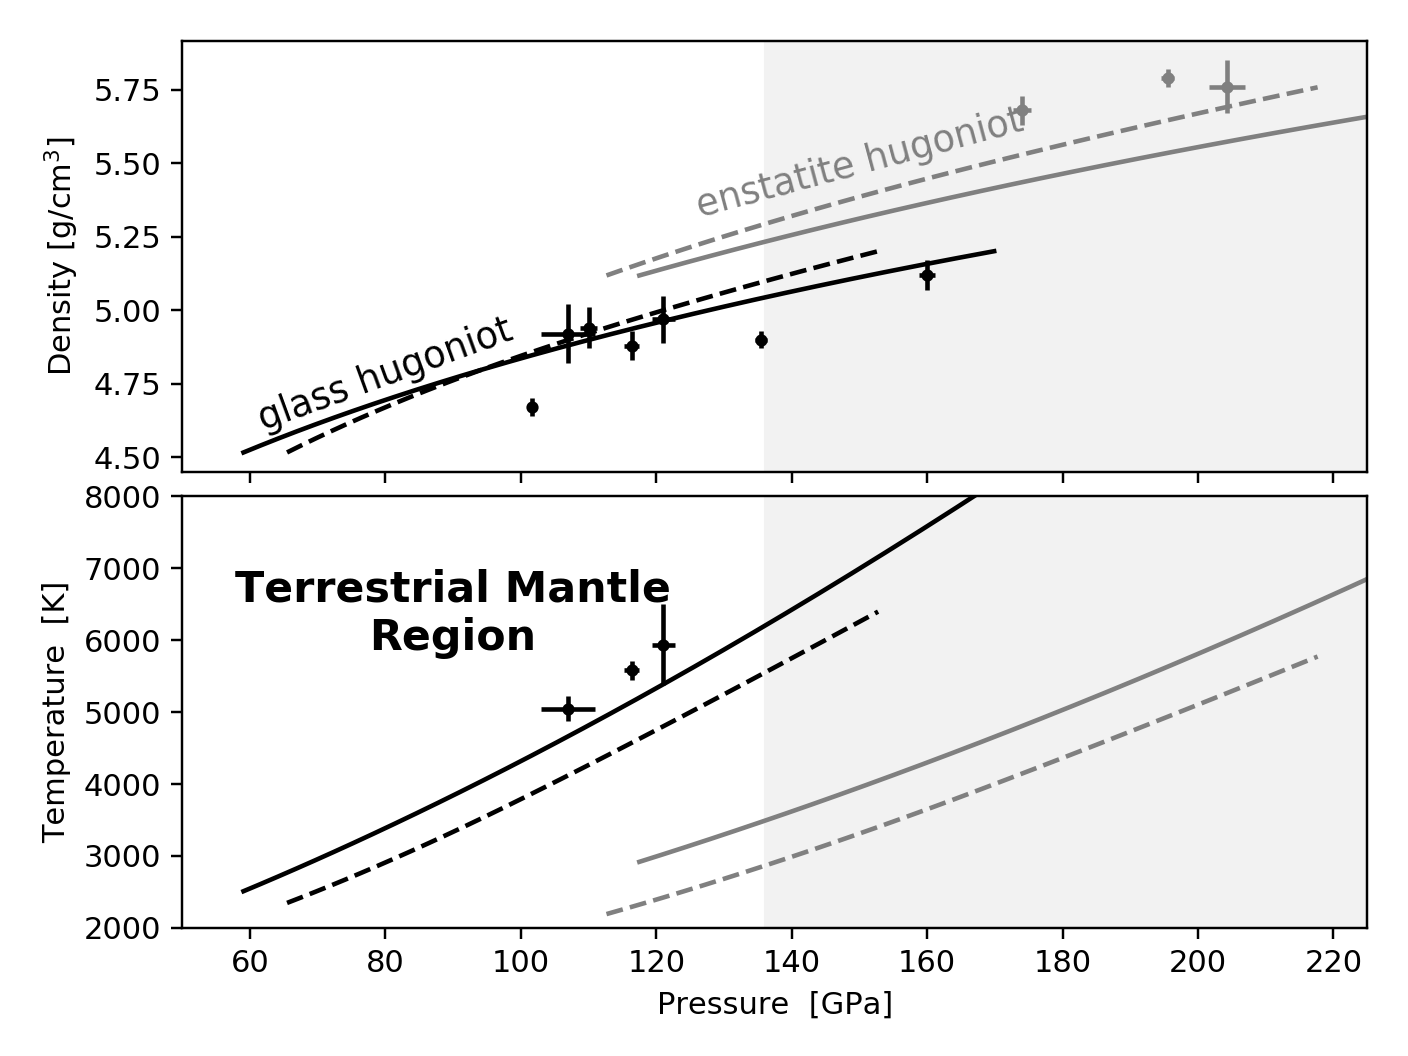

In [21]:
plot_hugoniot(shock_dat_melt_glass, shock_dat_melt_en,
                  hugoniot_glass_S11, hugoniot_en_S11,
                  hugoniot_glass_dK09, hugoniot_en_dK09)
plt.savefig('figs/hugoniot.eps', dpi=450)

In [22]:

# Tfoot_grid = np.arange(2000,9001,1000)
Tlbl = [2000,2250,2500,2750,3000,3250,3500]
delT = Tlbl[1]-Tlbl[0]
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
Tfoot_grid = Tlbl
Pgrid = np.arange(0,550.1,1)
eos_mod.apply_electronic = True
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid, Pgrid)

eos_mod_dK09.apply_electronic = True
Vad_grid_dK09, Tad_grid_dK09 = eos_mod_dK09.adiabatic_path_grid(Tfoot_grid, Pgrid)

<IPython.core.display.Javascript object>


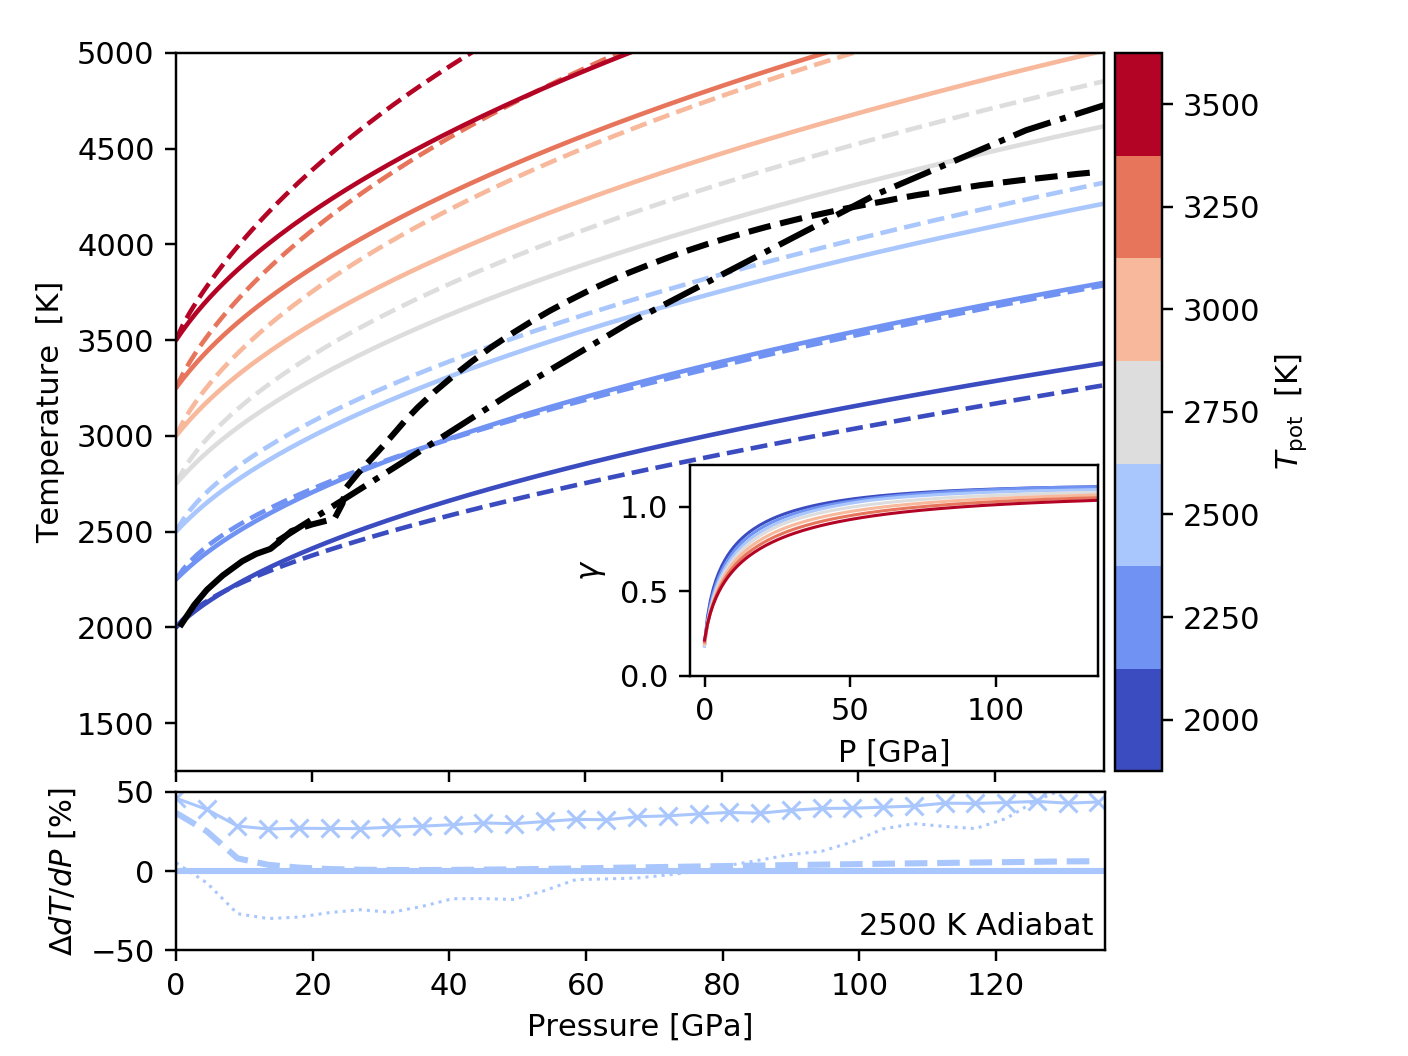

Avg Thermal Derivative
Spera11 =  11.1207950154
Mosenfelder09 =  10.7576980873 -3.26502671499
deKoker09 =  11.4346564421 2.82229306651
Stixrude09 =  14.8448874605 33.4876458014


In [23]:
cmap = plt.get_cmap('coolwarm',len(Tlbl))
plot_adiabat_melting_curve(Tlbl, Pgrid, Tad_grid, Tad_grid_dK09, 
              Vad_grid, Vad_grid_dK09)

fig = plt.gcf()


ax_sub = fig.add_axes([.49,.36,.29,.2])
for Vad, Vad_dK09, Tad, Tad_dK09, iTpot in zip(
    Vad_grid, Vad_grid_dK09, Tad_grid, Tad_grid_dK09, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod.gamma(Vad,Tad)
    igamma_ad_dK09 = eos_mod_dK09.gamma(Vad_dK09,Tad_dK09)
    ax_sub.plot(Pgrid,igamma_ad, '-', color=icol,lw=1)
    
ax_sub.set_ylim(0,1.25)
ax_sub.set_xlim(-5,135)
ax_sub.set_xlabel('P [GPa]')
ax_sub.set_ylabel(r'$\gamma$')
plt.savefig('figs/adiabat-comparison.eps', dpi=450)

<IPython.core.display.Javascript object>


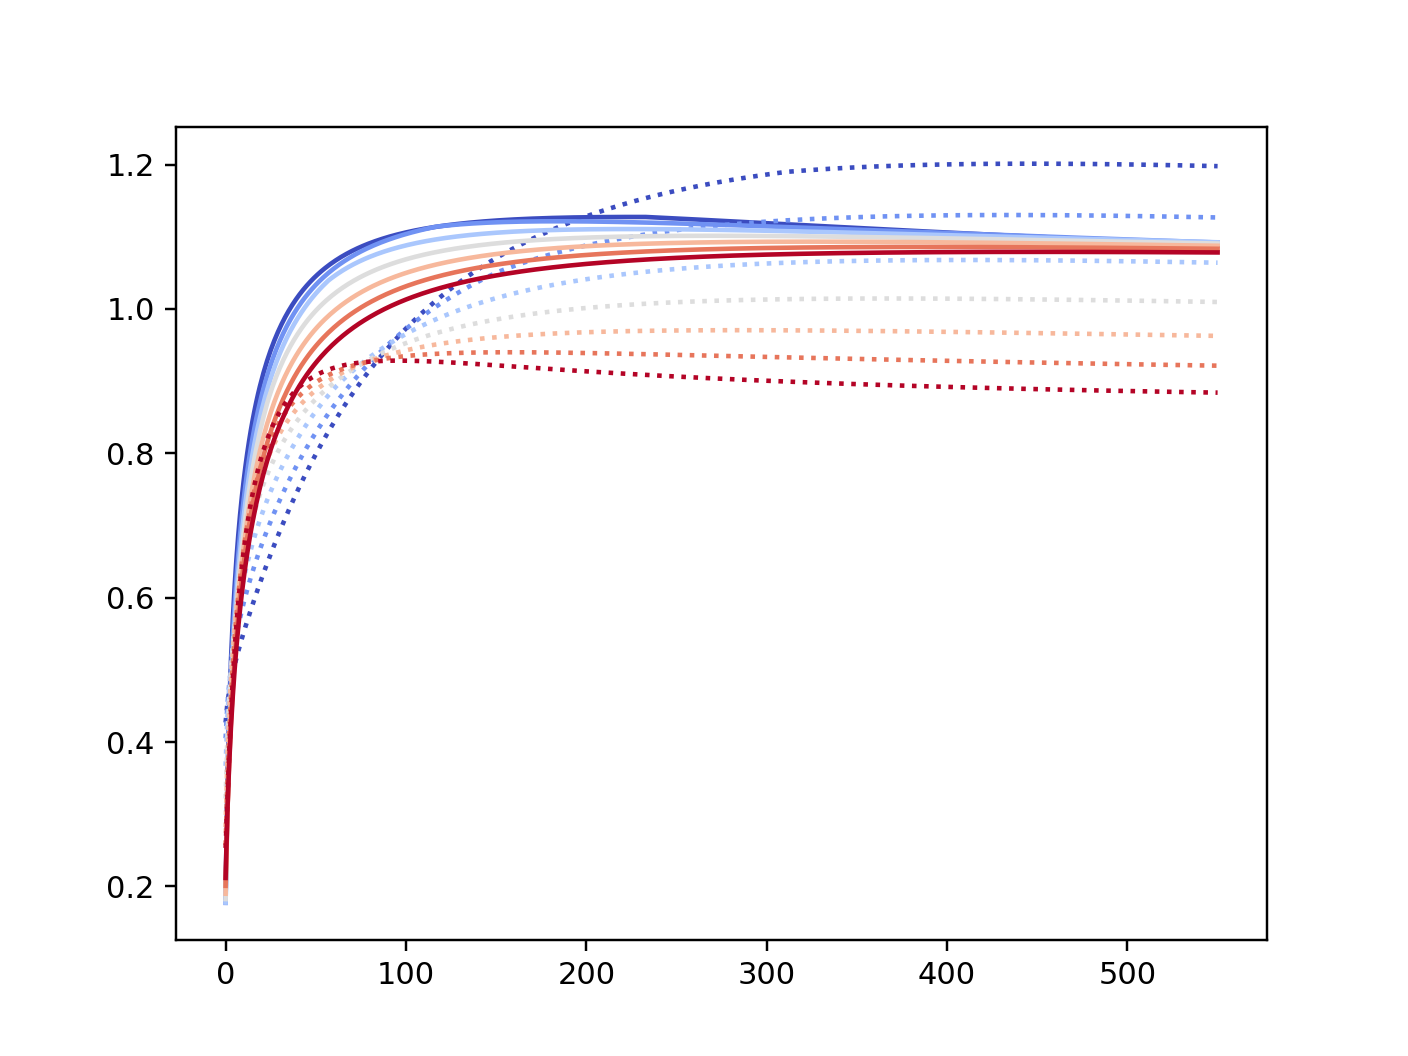

In [23]:
plt.figure()
for Vad, Vad_dK09, Tad, Tad_dK09, iTpot in zip(
    Vad_grid, Vad_grid_dK09, Tad_grid, Tad_grid_dK09, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod.gamma(Vad,Tad)
    igamma_ad_dK09 = eos_mod_dK09.gamma(Vad_dK09,Tad_dK09)
    plt.plot(Pgrid,igamma_ad, '-', 
            Pgrid, igamma_ad_dK09,':', color=icol)
    #plt.plot(Pgrid,igamma_T, ':', color=icol)


<IPython.core.display.Javascript object>


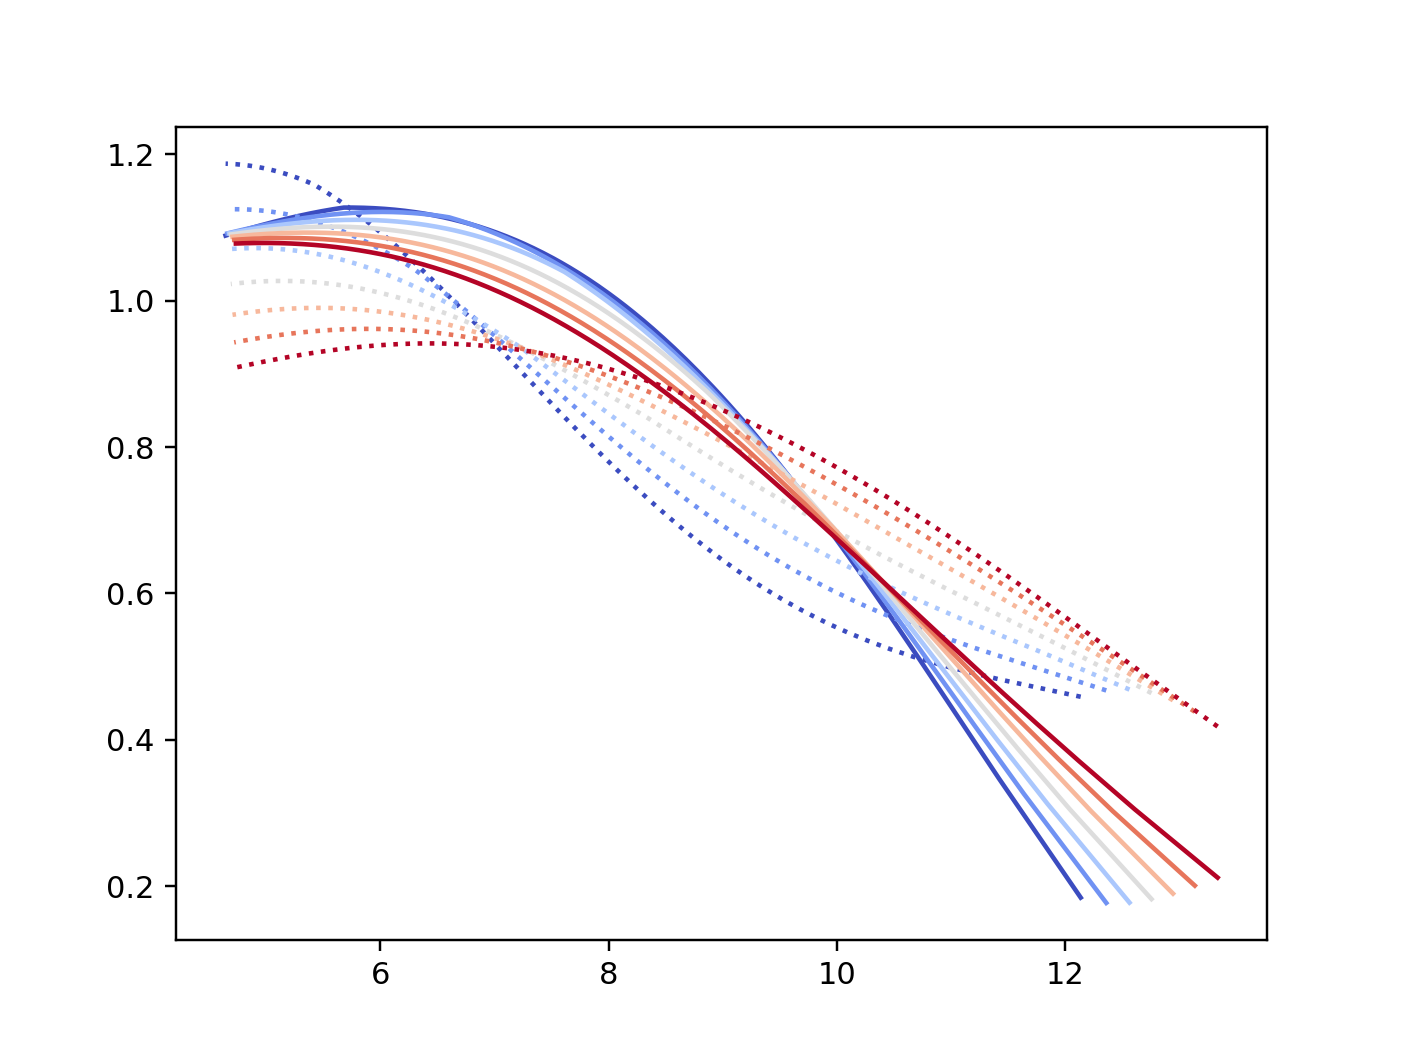

In [24]:
eos_mod.apply_electronic = True
eos_mod_dK09.apply_electronic = True

plt.figure()
for Vad, Tad, iTpot in zip(Vad_grid, Tad_grid, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod.gamma(Vad,Tad)
    igamma_ad_dK09 = eos_mod_dK09.gamma(Vad,Tad)
    # igamma_T = eos_mod.gamma(Vad, iTpot)
    plt.plot(Vad,igamma_ad, '-', 
            Vad, igamma_ad_dK09,':', color=icol)
    #plt.plot(Pgrid,igamma_T, ':', color=icol)
